# **Fake News Detection**

# **Project Description**



In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from ydata_profiling import ProfileReport

In [2]:
wel_fake = pd.read_csv('data/WELFake_Dataset.csv')
fake_news_net = pd.read_csv('data/FakeNewsNet.csv')
true = pd.read_csv('data/true.csv')
fake = pd.read_csv('data/fake.csv')

In [3]:
wel_fake

,Unnamed: 0,title,text,label
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,1,NaN,Did they post their votes for Hillary already?,1
2,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1
...,...,...,...,...
72129,72129,Russians steal research on Trump in hack of U....,WASHINGTON (Reuters) - Hackers believed to be ...,0
72130,72130,WATCH: Giuliani Demands That Democrats Apolog...,"You know, because in fantasyland Republicans n...",1
72131,72131,Migrants Refuse To Leave Train At Refugee Camp...,Migrants Refuse To Leave Train At Refugee Camp...,0
72132,72132,Trump tussle gives unpopular Mexican leader mu...,MEXICO CITY (Reuters) - Donald Trump’s combati...,0


In [4]:
fake_news_net.head(60)

,title,news_url,source_domain,tweet_num,real
0,Kandi Burruss Explodes Over Rape Accusation on...,http://toofab.com/2017/05/08/real-housewives-a...,toofab.com,42,1
1,People's Choice Awards 2018: The best red carp...,https://www.today.com/style/see-people-s-choic...,www.today.com,0,1
2,Sophia Bush Sends Sweet Birthday Message to 'O...,https://www.etonline.com/news/220806_sophia_bu...,www.etonline.com,63,1
3,Colombian singer Maluma sparks rumours of inap...,https://www.dailymail.co.uk/news/article-33655...,www.dailymail.co.uk,20,1
4,Gossip Girl 10 Years Later: How Upper East Sid...,https://www.zerchoo.com/entertainment/gossip-g...,www.zerchoo.com,38,1
5,Gwen Stefani Got Dumped by Blake Shelton Over ...,www.intouchweekly.com/posts/gwen-stefani-dumpe...,www.intouchweekly.com,45,0
6,Broward County Sheriff Fired For Lying About P...,https://yournewswire.com/broward-county-sherif...,yournewswire.com,124,0
7,Amber Rose Shuts Down French Montana Dating Ru...,www.etonline.com/news/214798_amber_rose_shuts_...,www.etonline.com,4,0
8,Mindy Kaling makes first post-baby appearance ...,https://www.aol.com/article/entertainment/2018...,www.aol.com,59,1
9,Katharine McPhee Butchers Tony Nominations: “I...,https://www.98online.com/2018/05/02/katharine-...,www.98online.com,10,1


In [5]:
fake['label'] = 0

true['label'] = 1

In [6]:
fake_true = pd.concat([fake, true]).reset_index(drop=True)

In [7]:
fake_true

,title,text,subject,date,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0
...,...,...,...,...,...
44893,'Fully committed' NATO backs new U.S. approach...,BRUSSELS (Reuters) - NATO allies on Tuesday we...,worldnews,"August 22, 2017",1
44894,LexisNexis withdrew two products from Chinese ...,"LONDON (Reuters) - LexisNexis, a provider of l...",worldnews,"August 22, 2017",1
44895,Minsk cultural hub becomes haven from authorities,MINSK (Reuters) - In the shadow of disused Sov...,worldnews,"August 22, 2017",1
44896,Vatican upbeat on possibility of Pope Francis ...,MOSCOW (Reuters) - Vatican Secretary of State ...,worldnews,"August 22, 2017",1


<AxesSubplot: ylabel='label'>

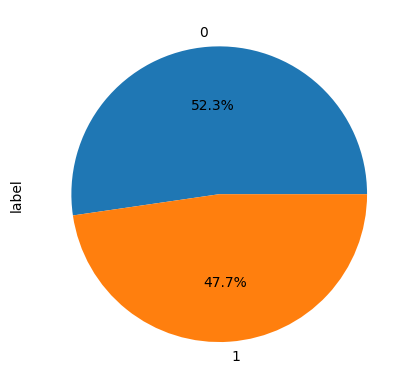

In [8]:
fake_true.groupby('label')['label'].count().plot(kind='pie', autopct='%1.1f%%')

In [9]:
fake_true.groupby(['subject', 'label']).count()

,,title,text,date
subject,label,,,
Government News,0,1570,1570,1570
Middle-east,0,778,778,778
News,0,9050,9050,9050
US_News,0,783,783,783
left-news,0,4459,4459,4459
politics,0,6841,6841,6841
politicsNews,1,11272,11272,11272
worldnews,1,10145,10145,10145


In [12]:
ProfileReport(wel_fake, title='WELFake').to_file('WELFake.html')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [13]:
ProfileReport(fake_news_net, title='FakeNewsNet').to_file('FakeNewsNet.html')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [14]:
ProfileReport(fake_true, title='FakeTrue').to_file('FakeTrue.html')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]